In [2]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import random
import time
import pandas as pd
import math
import csv
import os

t0=time.time()
###########################################################
###########################################################

# Esta celda define funciones y carga librerías.
# También sirve para levantar el nombre de los archivos, por lo que cada vez que armes
# nuevos archivos tenés que volver a correrla para volver a registrar los nuevos nombres

############################################################
############################################################

def scan(cant,lista):
    i=0
    for x in lista:
        print(x)
        i+=1
        if i>cant:
            break
            
def Tiempo():
    t1=time.time()
    print("Esto tardó {} segundos".format(t1-t0))


def ldata(archive):
        f = open(archive)
        data = []
        for line in f:
            col = line.split("\t")
            col = [x.strip() for x in col]
            data.append(col)
        return data 
    
# Vamos a leer los archivos con esta celda. Al darle la dirección de la carpeta Datos, lo que estoy sacando
# son los nombres de todos los archivos en esa carpeta.
#--------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

Tiempo()

Esto tardó 0.0010101795196533203 segundos


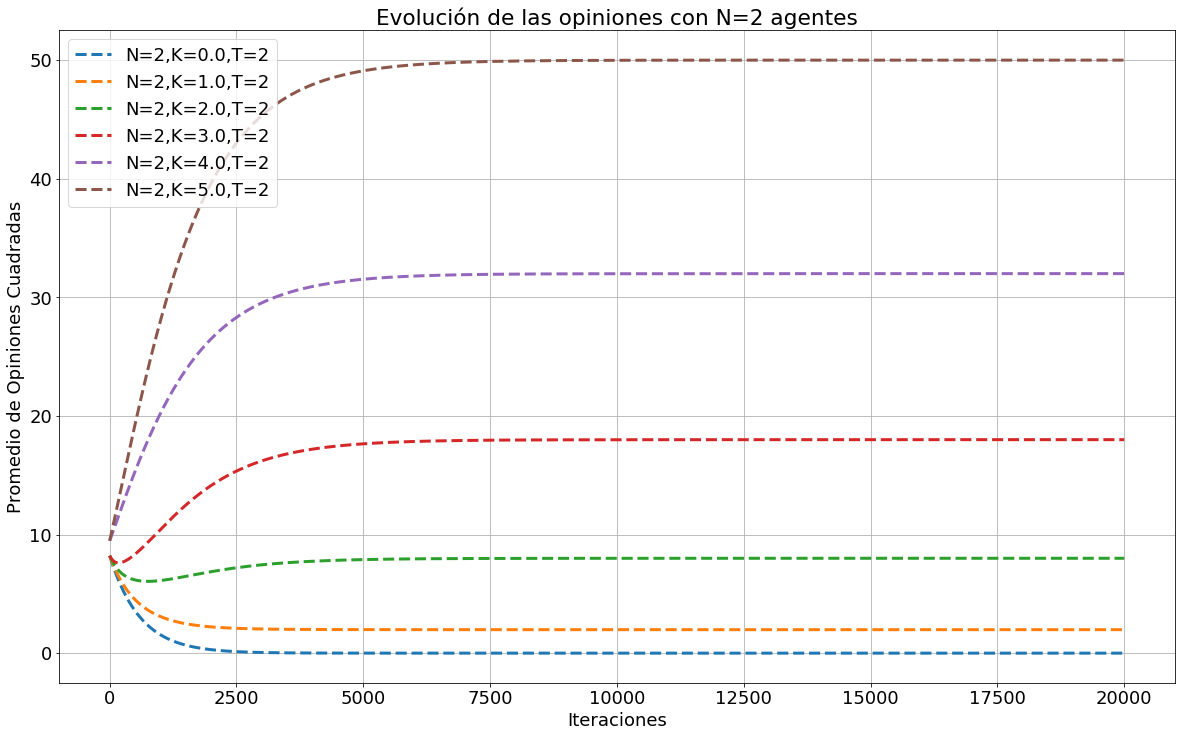

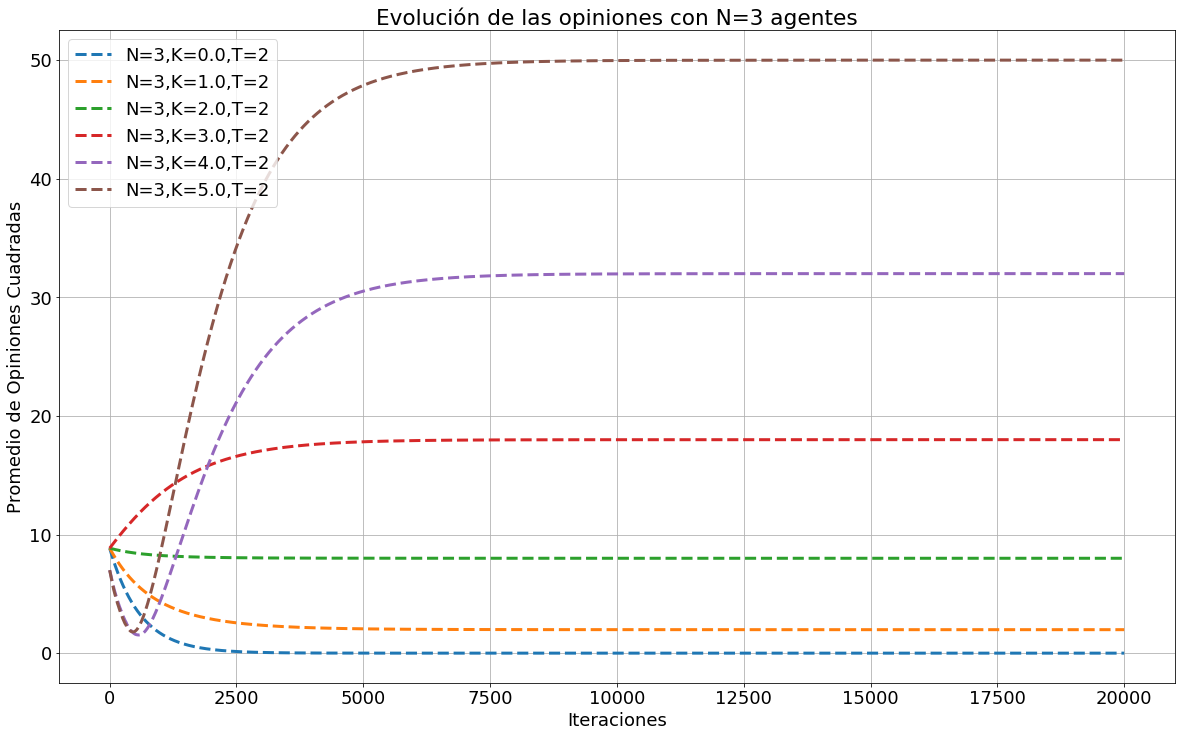

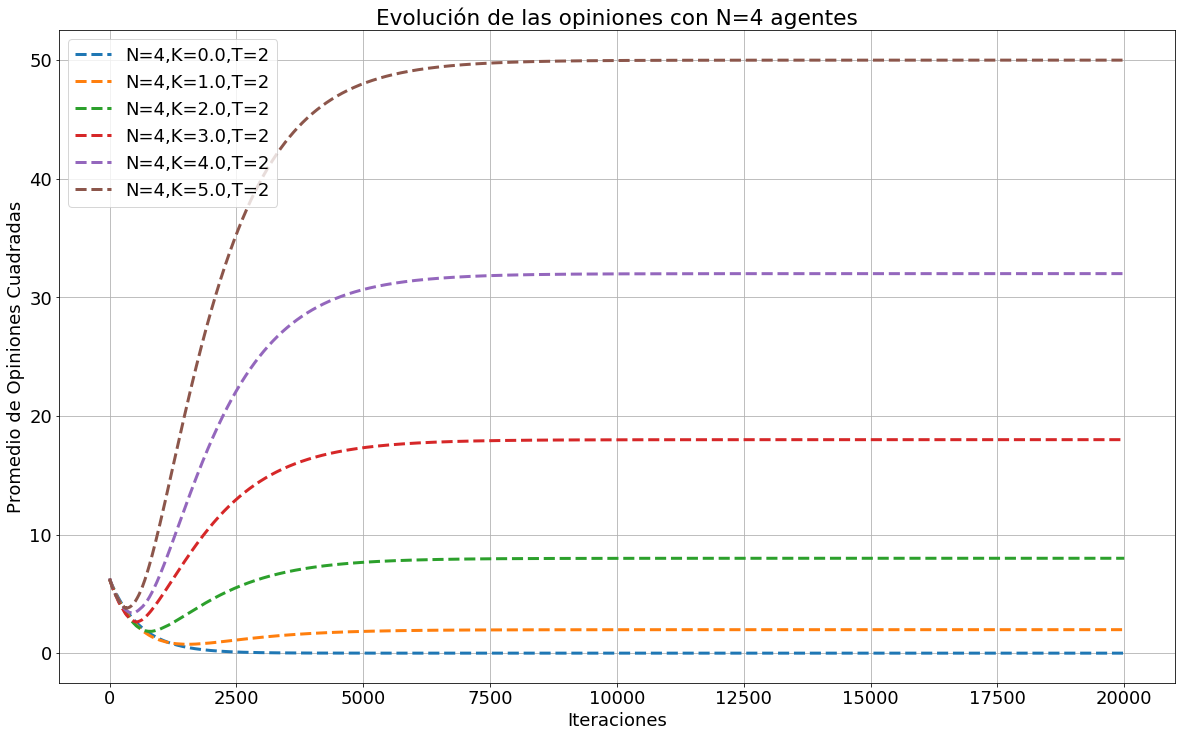

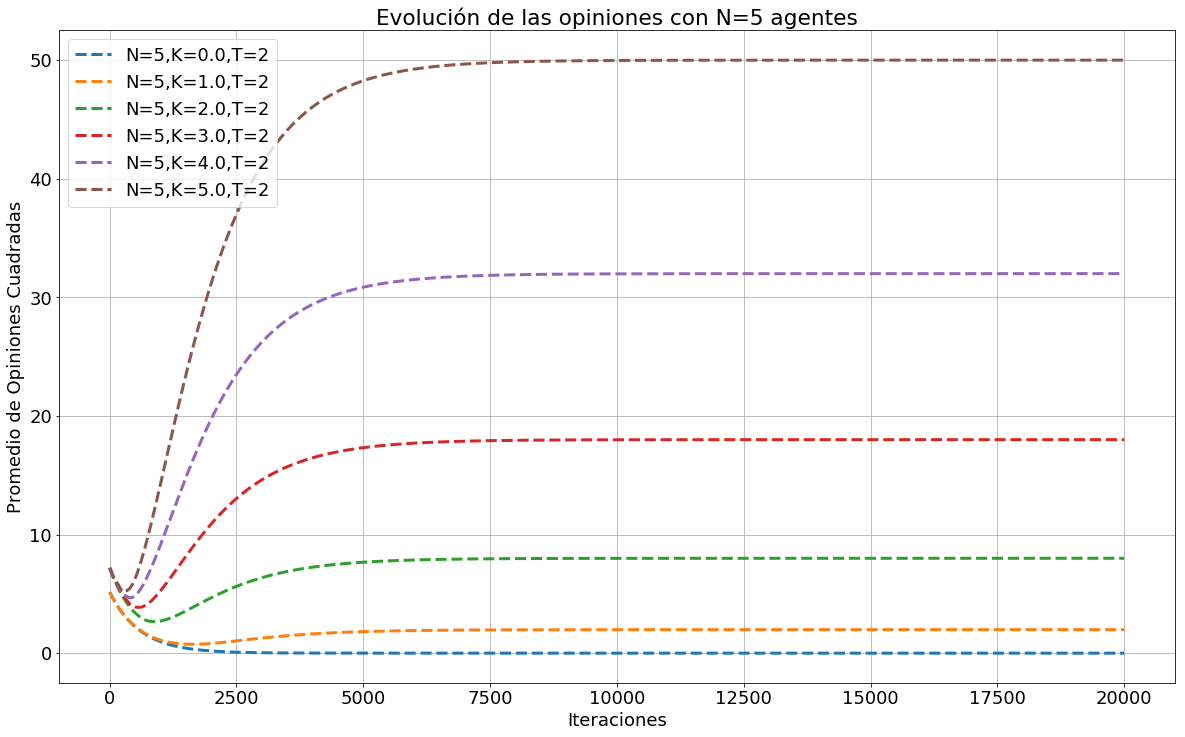

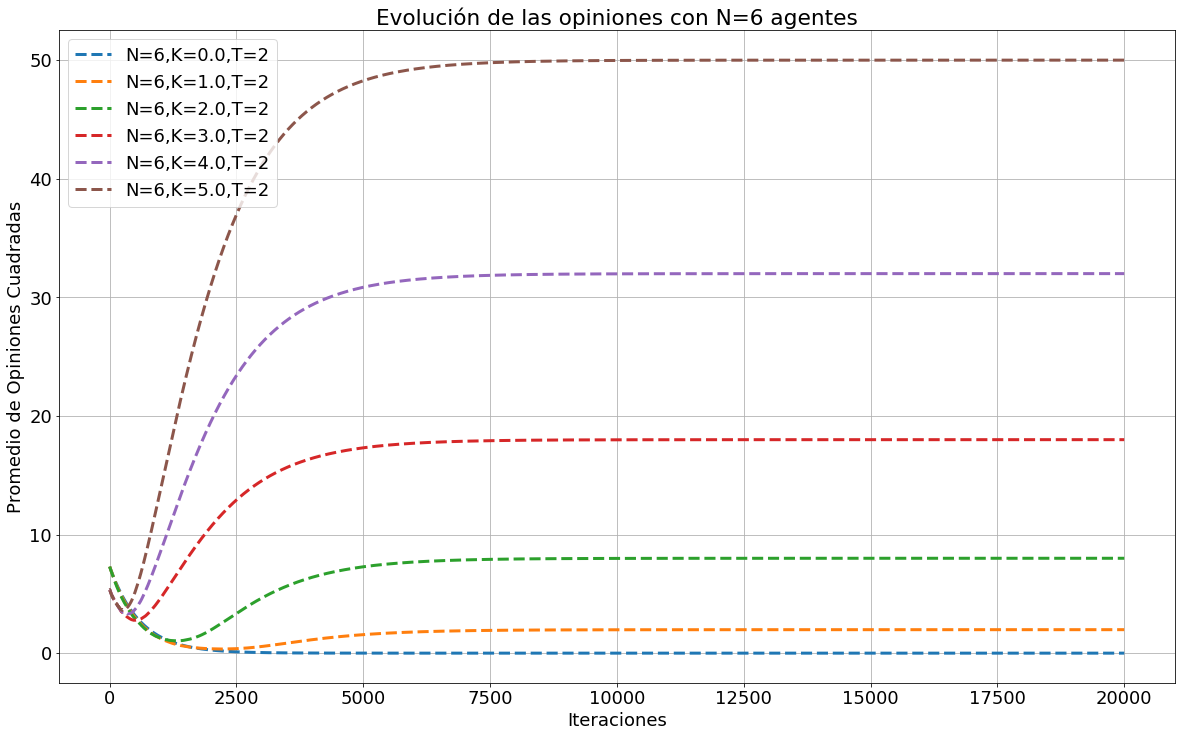

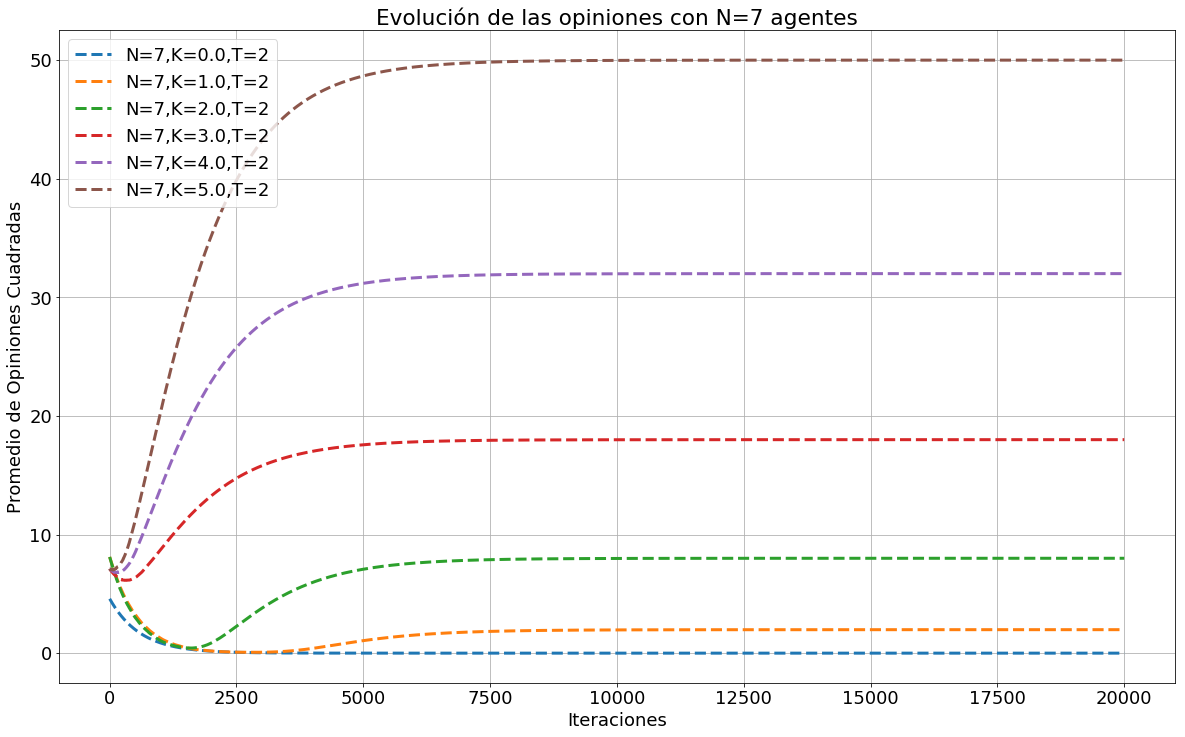

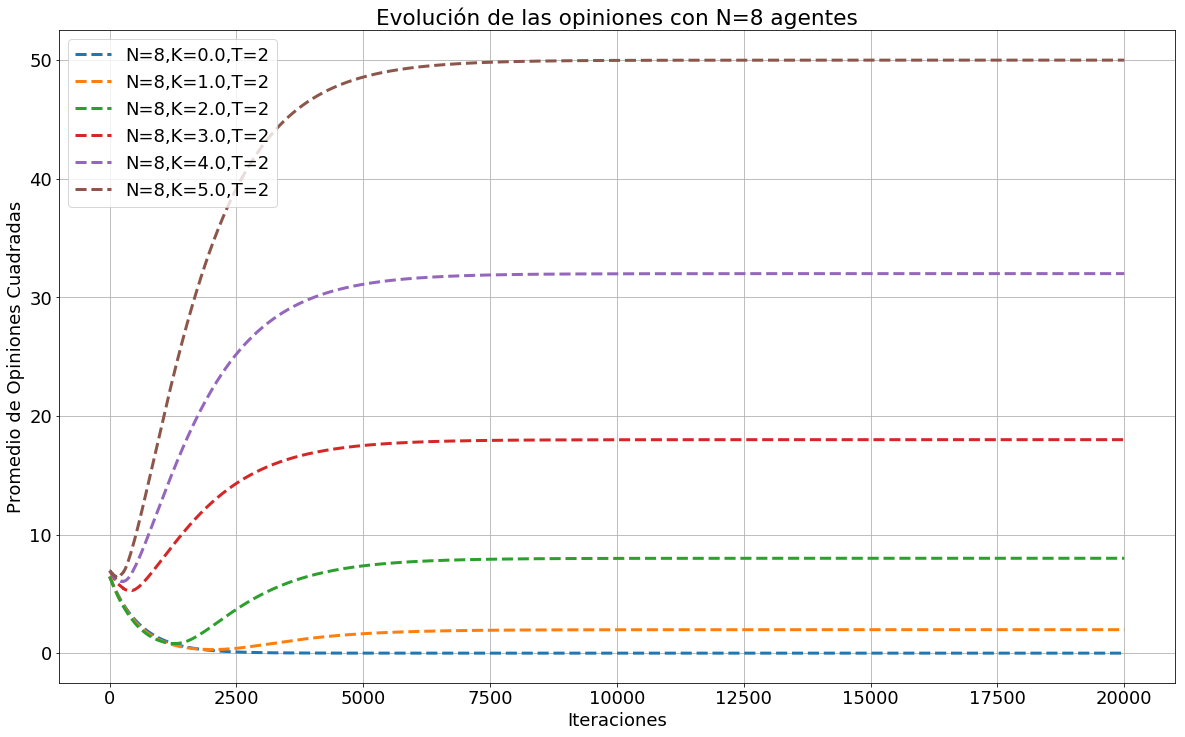

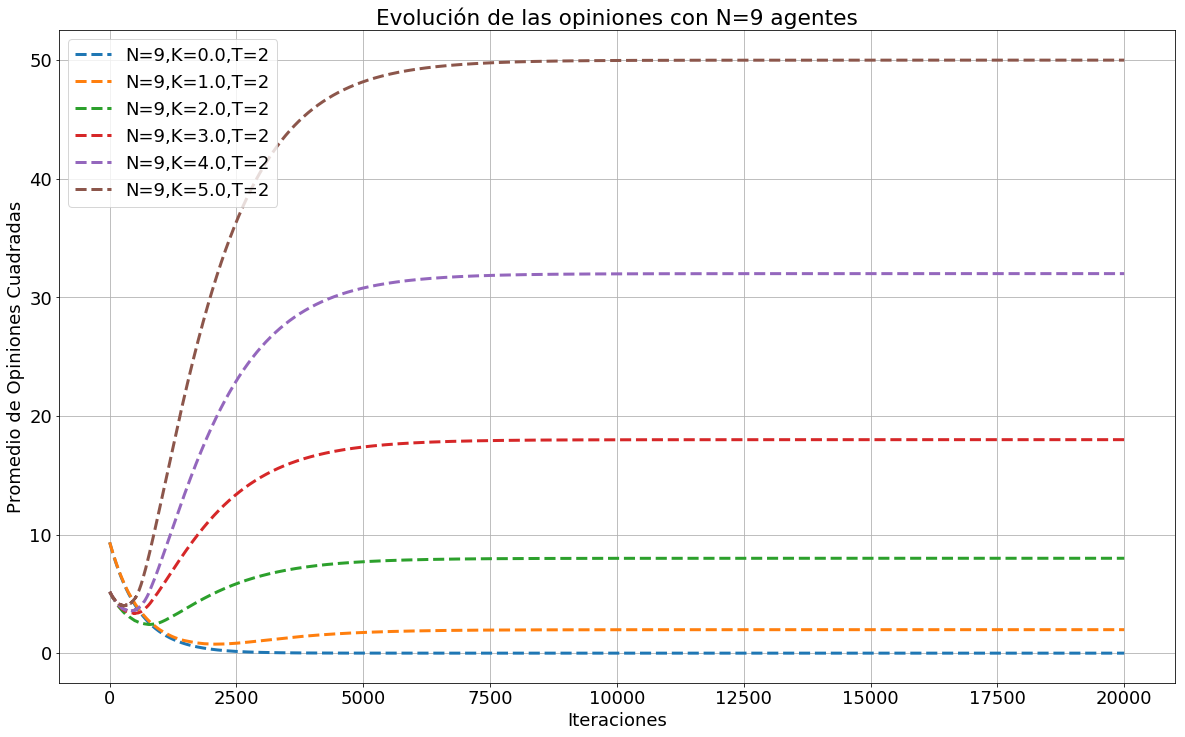

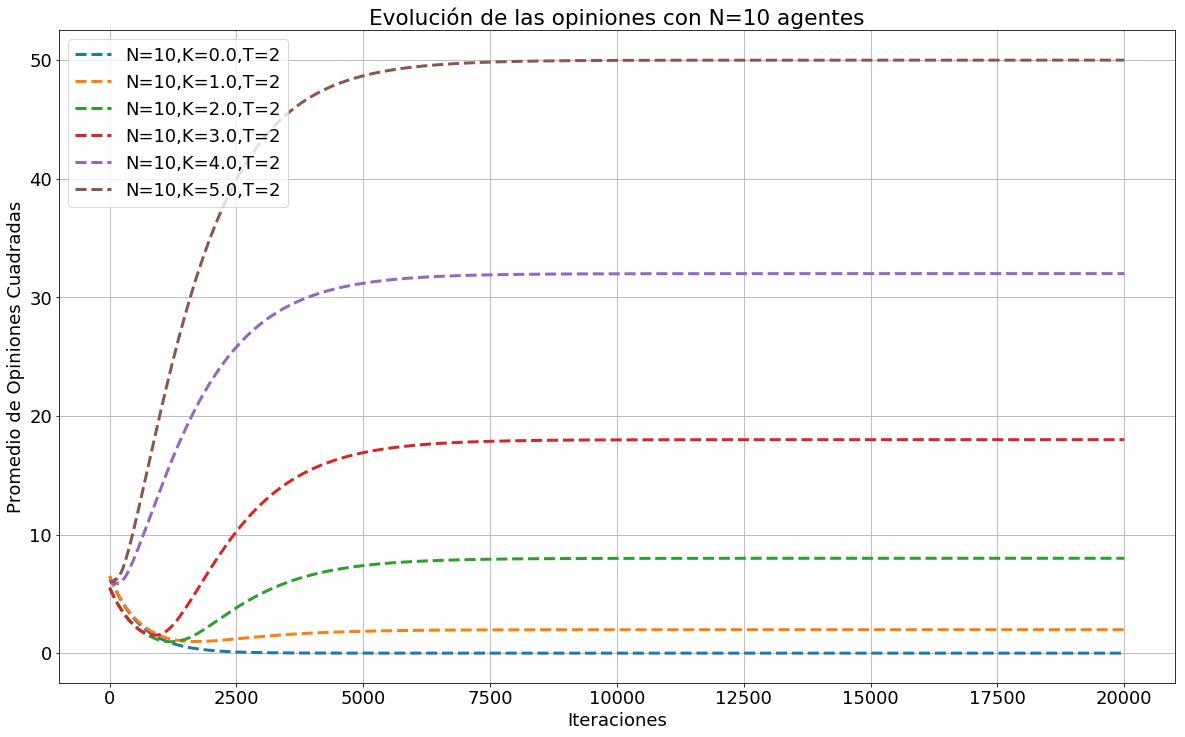

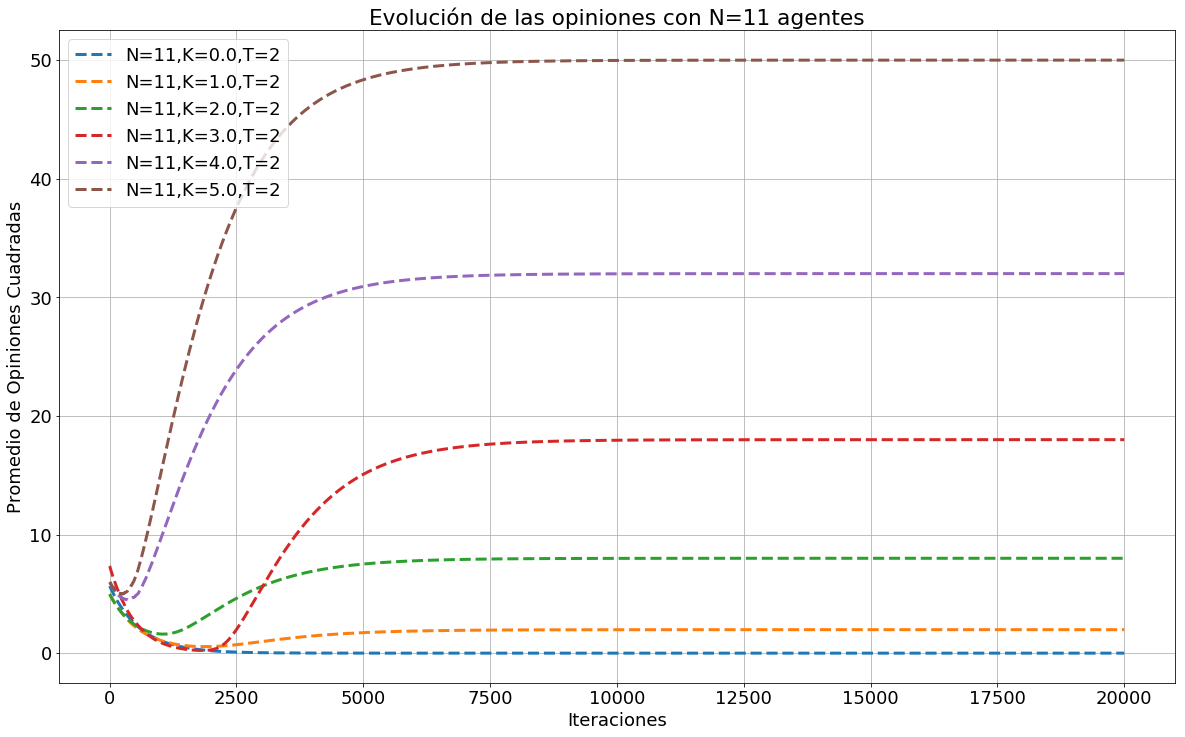

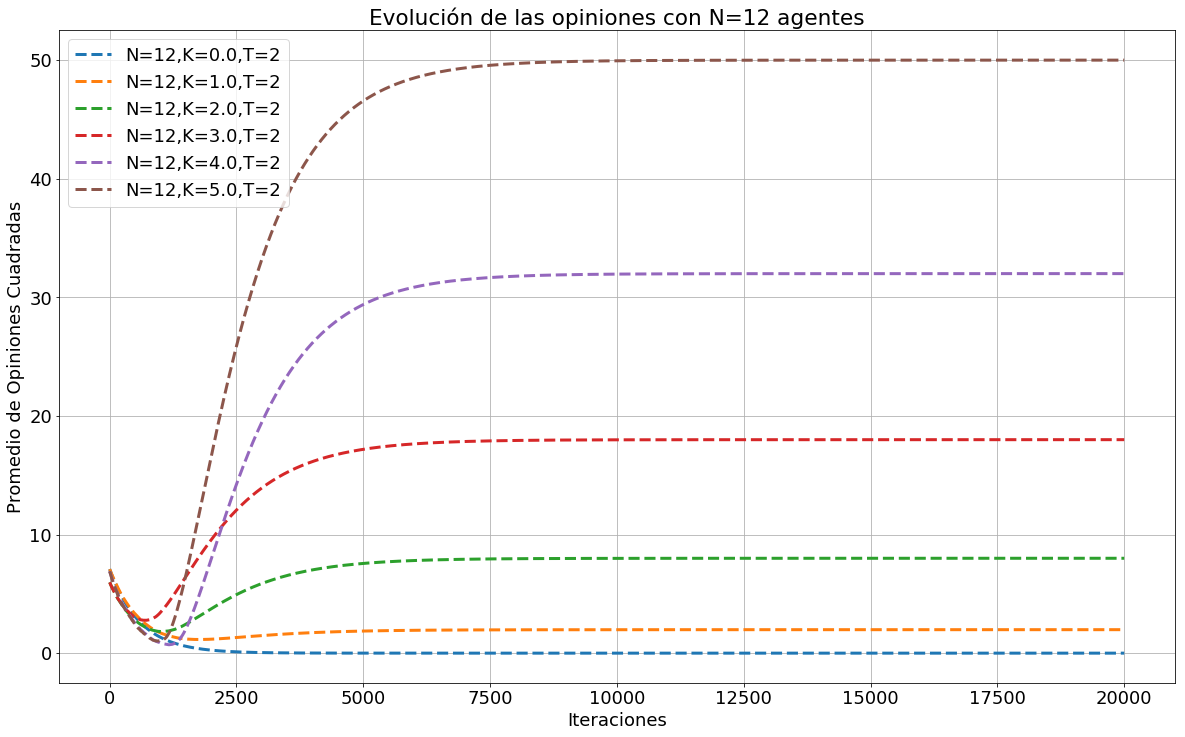

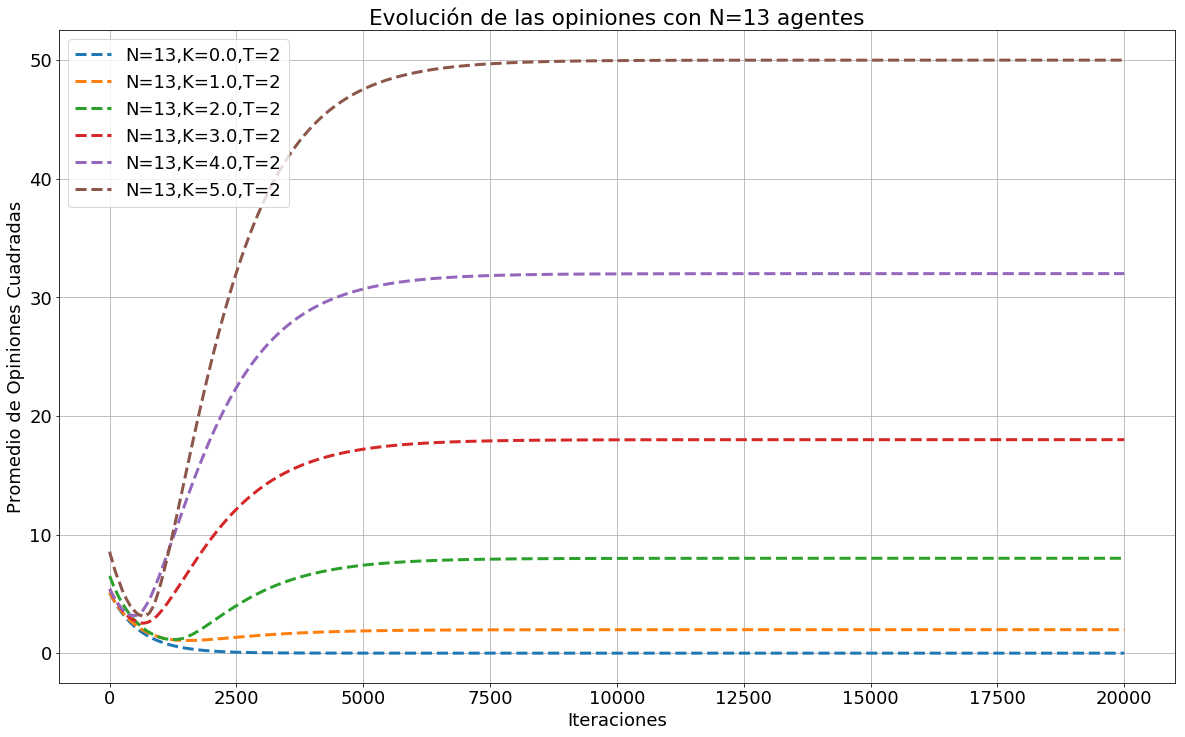

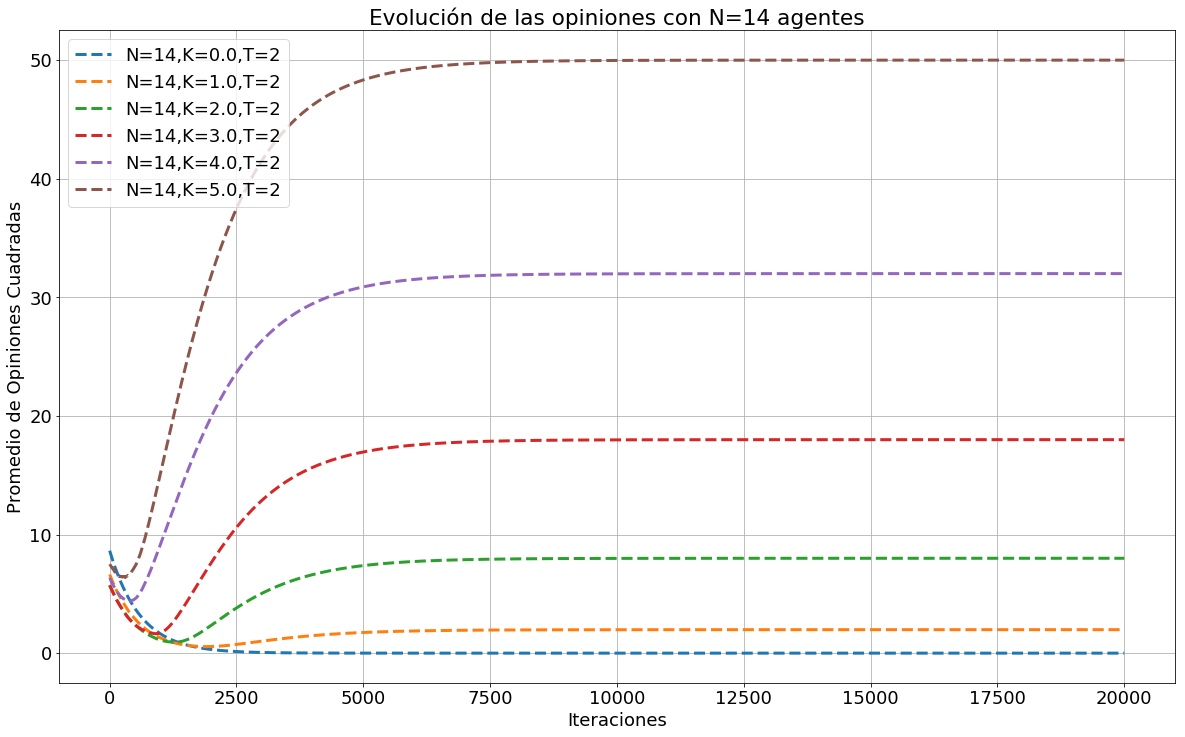

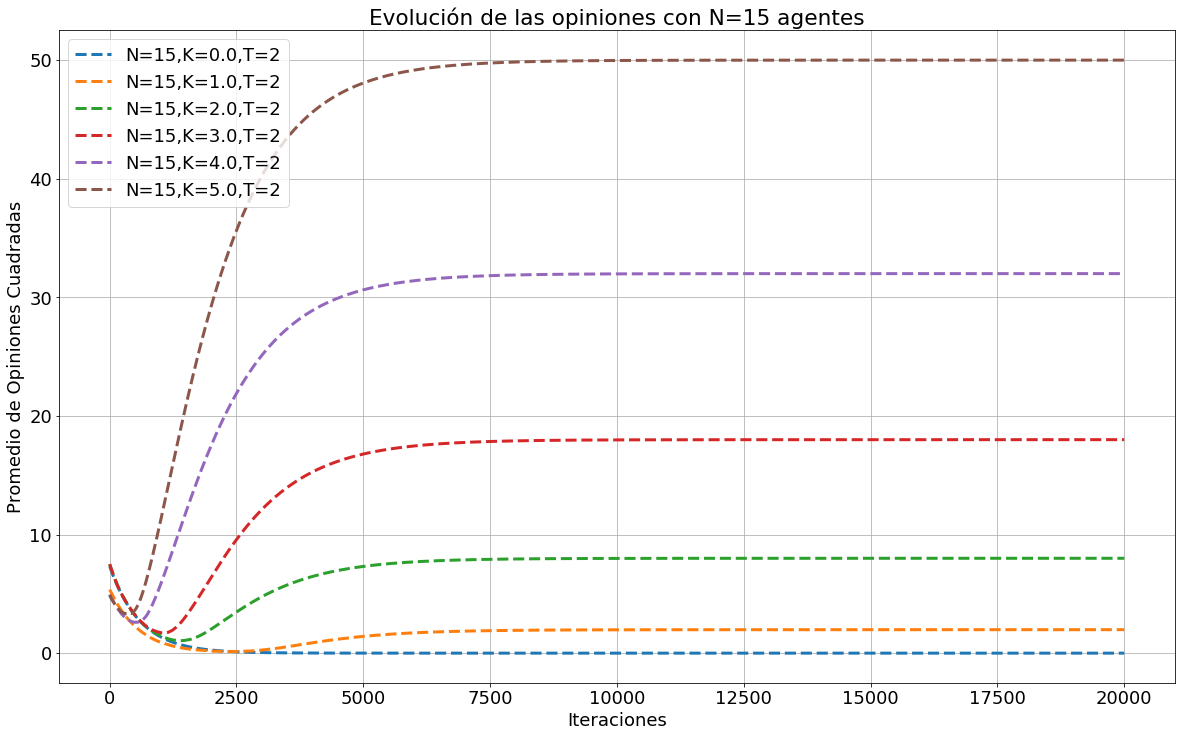

Esto tardó 71.98956727981567 segundos


In [7]:
t0=time.time()

# En esta celda voy a levantar los datos de opiniones y buscar encontrar el valor de error que
# me permita definir un criterio de corte para mi función principal
#-------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a construir la lista de Nombres de Opiniones


Nombres_Opiniones = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Evolucion":
        Nombres_Opiniones.append(nombre)



# Bien, las listas de nombres de archivos ya se arman correctamente

#-----------------------------------------------------------------------------

# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuál es el máximo y mínimo número de agentes. Por razones.

Nmin = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])
Nmax = int(Nombres_Opiniones[1].split("_")[3].split("=")[1])

# Defino un Nmin y Nmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
    N = int(nombre.split("_")[3].split("=")[1])
    Nmin = min(N,Nmin)
    Nmax = max(N,Nmax)

# Bien, esto ya me obtiene los valores de Nmin y Nmax correctamente

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de opiniones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Opiniones[1:len(Nombres_Opiniones)]:
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Evolucion_Opinion_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente
        if agentes==N:
            #--------------------------------------------------------------------------------------------

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Opiniones[0],nombre))

            Ady = Datos[1][1:len(Datos[1])] # Lista con elementos de la matriz de Adyacencia
            Ady = [int(x) for x in Ady]

            Sup = Datos[3][1:len(Datos[3])] # Lista con elementos de la matriz de Superposición
            Sup = [float(x) for x in Sup]

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Opi = [[float(x) for x in fila[1:len(fila)]] for fila in Datos[5:len(Datos)]]

            # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

            #--------------------------------------------------------------------------------------------

            # Hagamos un gráfico de estos datos
            # La idea es hacer una sumatoria del valor cuadrado de las opiniones de cada uno.
            # En otra celda empezaré a ver de hacer un gráfico que registre la trayectoria de la opinión de los agentes.

            X = np.arange(0,len(Opi))
            POC = {} # POC significa Promedio Opiniones Cuadradas.
            for j in range(T):
                # Obtengo los valores cuadrados de todos mis tópicos
                POC[j] = []
                for i in range(len(Opi)):
                    # TS es Tópicos Separados. Esta lista va a ir tomando todas las opiniones de un cierto tópico en una iteración
                    TS = [t**2 for t in Opi[i][j:len(Opi[i]):T]]
                    # Ahora los sumo y los agrego a mis vectores Y
                    POC[j].append(np.sum(TS)/len(TS))


            # El vector X con el número de iteraciones, así como el diccionario que guarda las opiniones de cada tópico por
            # separado funcionan correctamente. Ahora puedo cambiar el número de tópicos de mi sistema sin dramas.

            #-------------------------------------------------------------------------------------------

            # Hay que ver la forma de graficar esto correctamente, sin que estalle en términos de cantidad de
            # cosas graficadas, y que permita entenderse


            YT = np.zeros(len(Opi))
            for j in range(T):
                YT += np.array(POC[j])

            plt.plot(X,YT, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Promedio de Opiniones Cuadradas")
    plt.title("Evolución de las opiniones con N={} agentes".format(agentes))
    plt.legend()
    plt.grid()
    plt.savefig("../Imagenes/Opiniones_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.show()


# El graficado de la función va bien, pero todavía siento que no puede bancarse cualquier cambio. Tengo que
# considerar un poco más los posibles casos.

Tiempo()

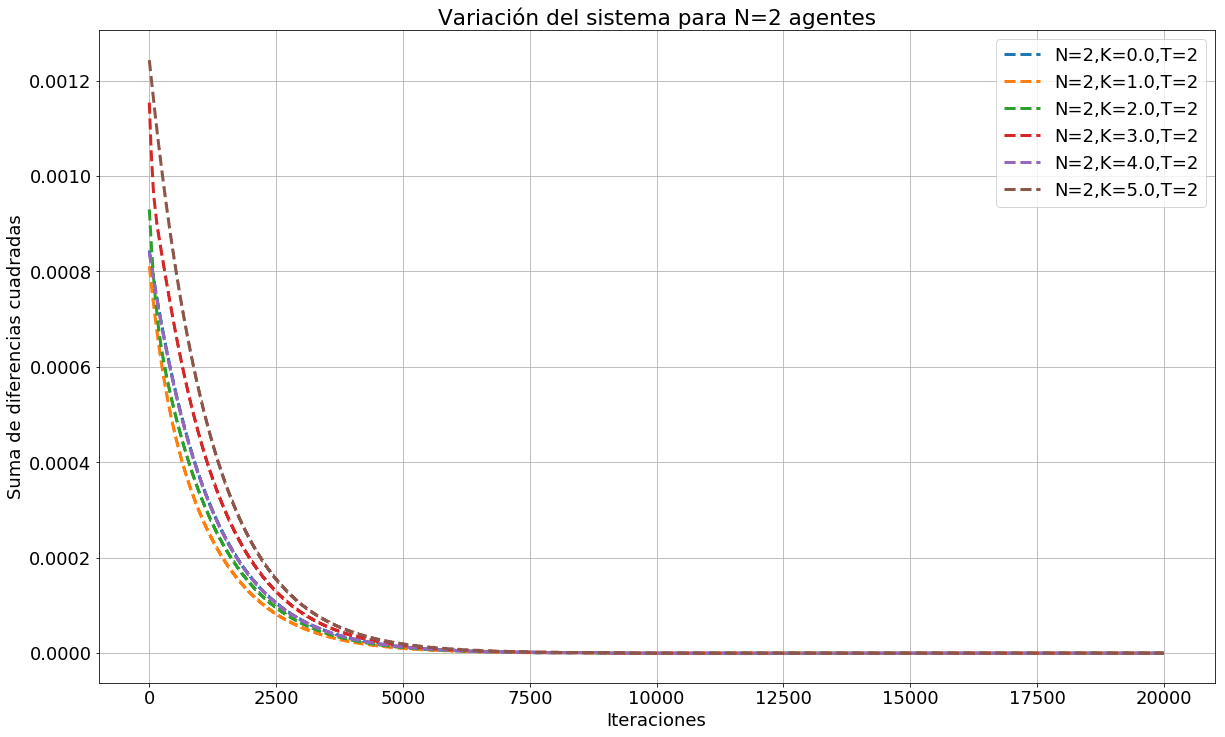

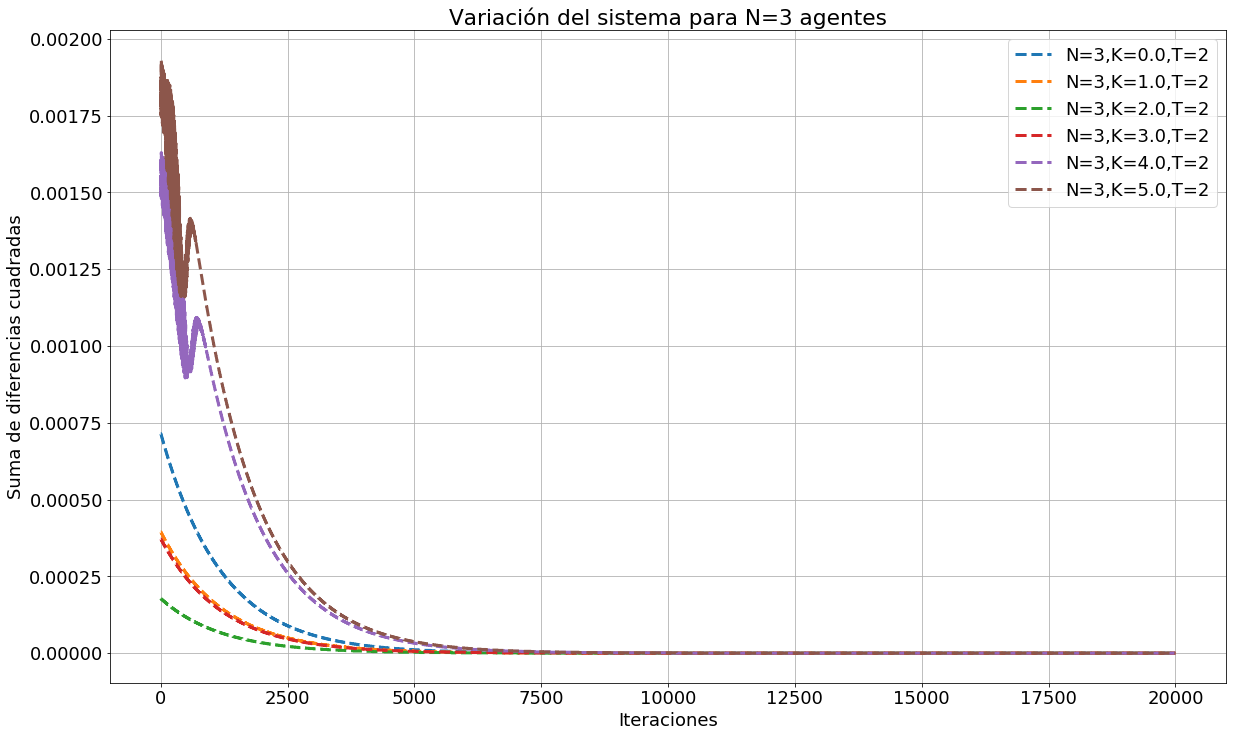

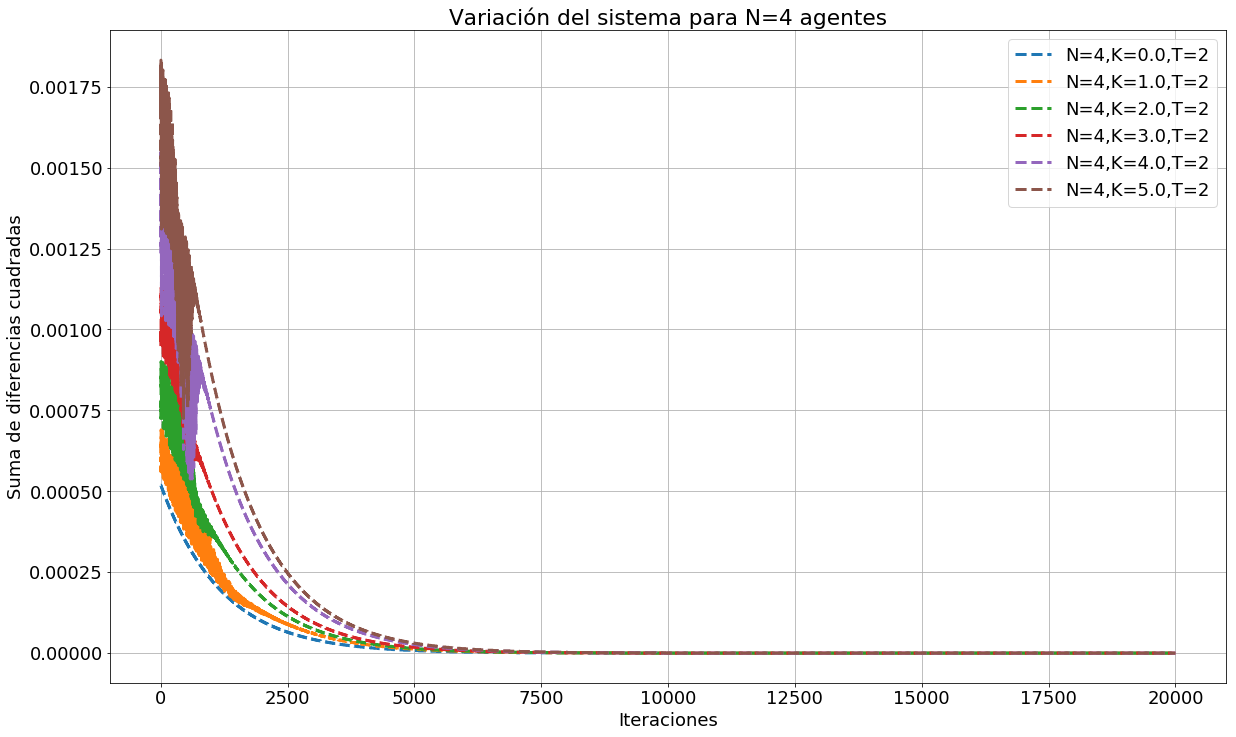

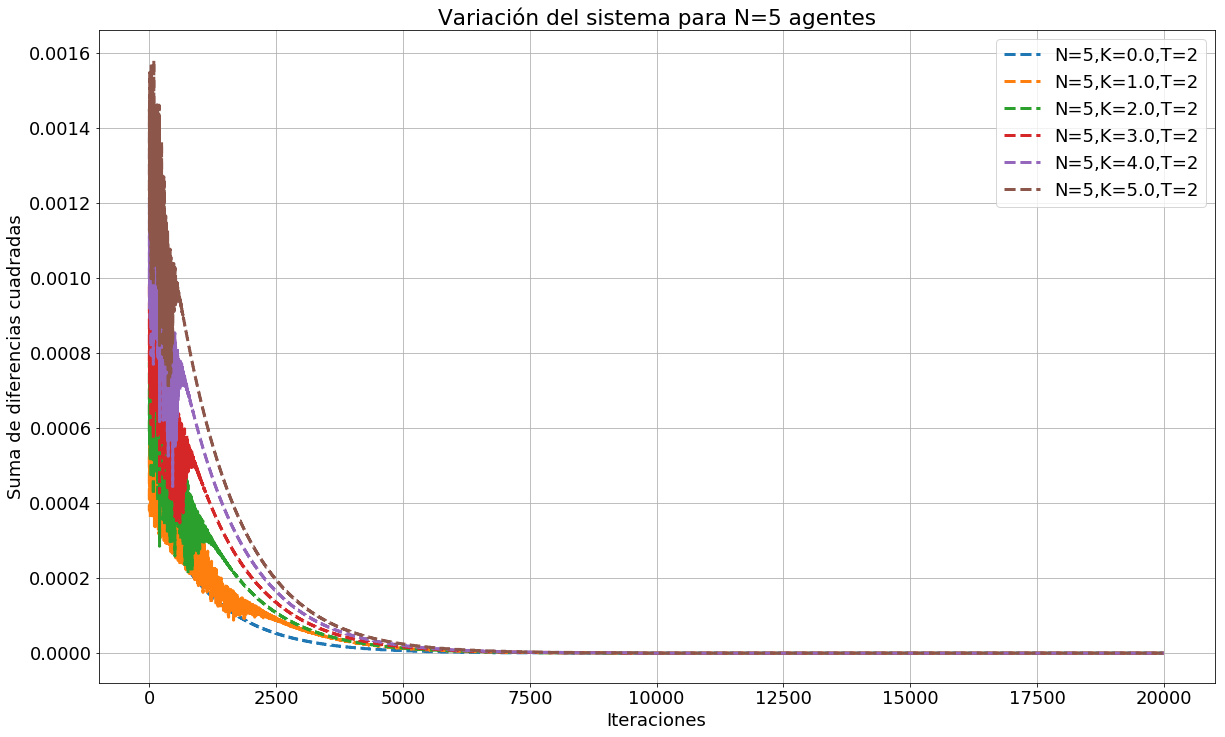

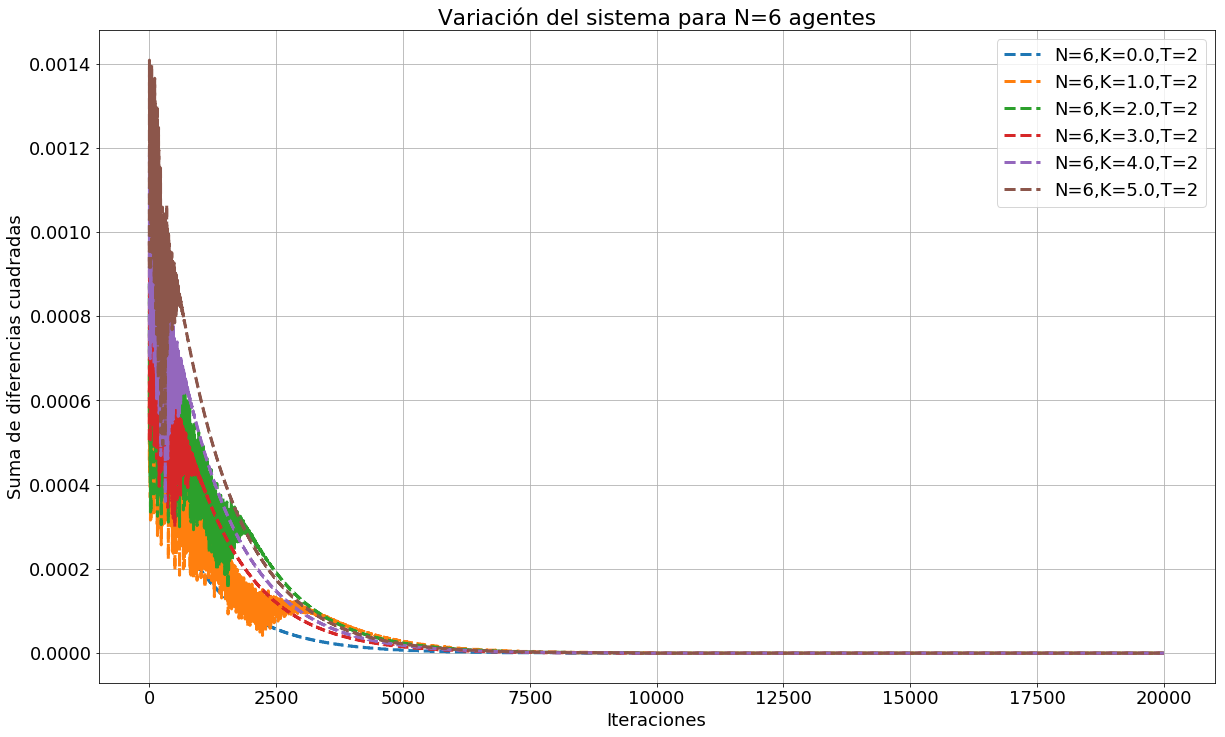

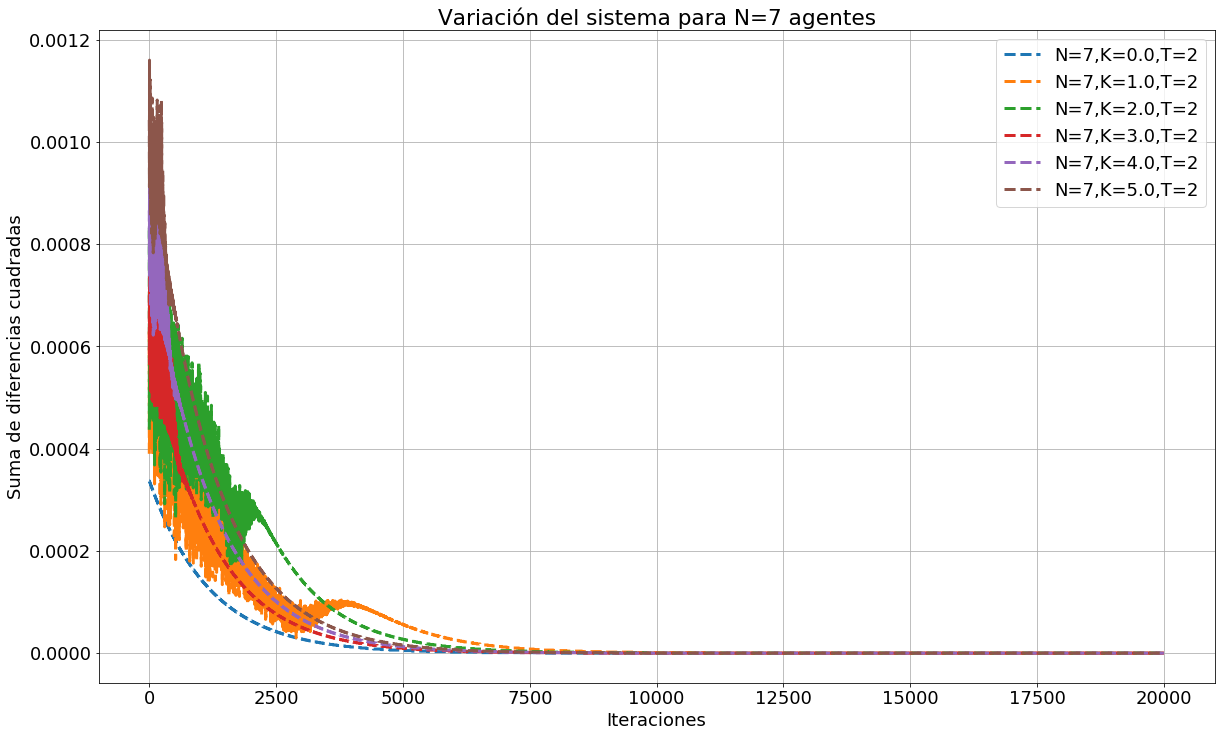

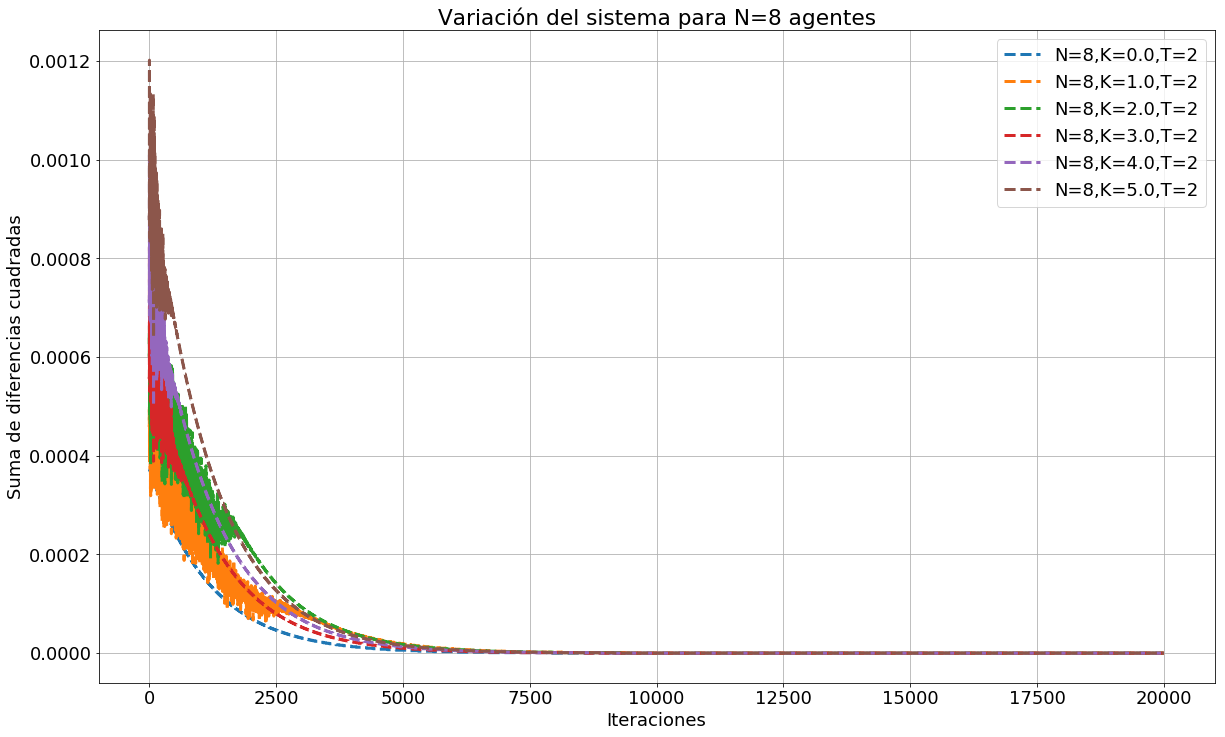

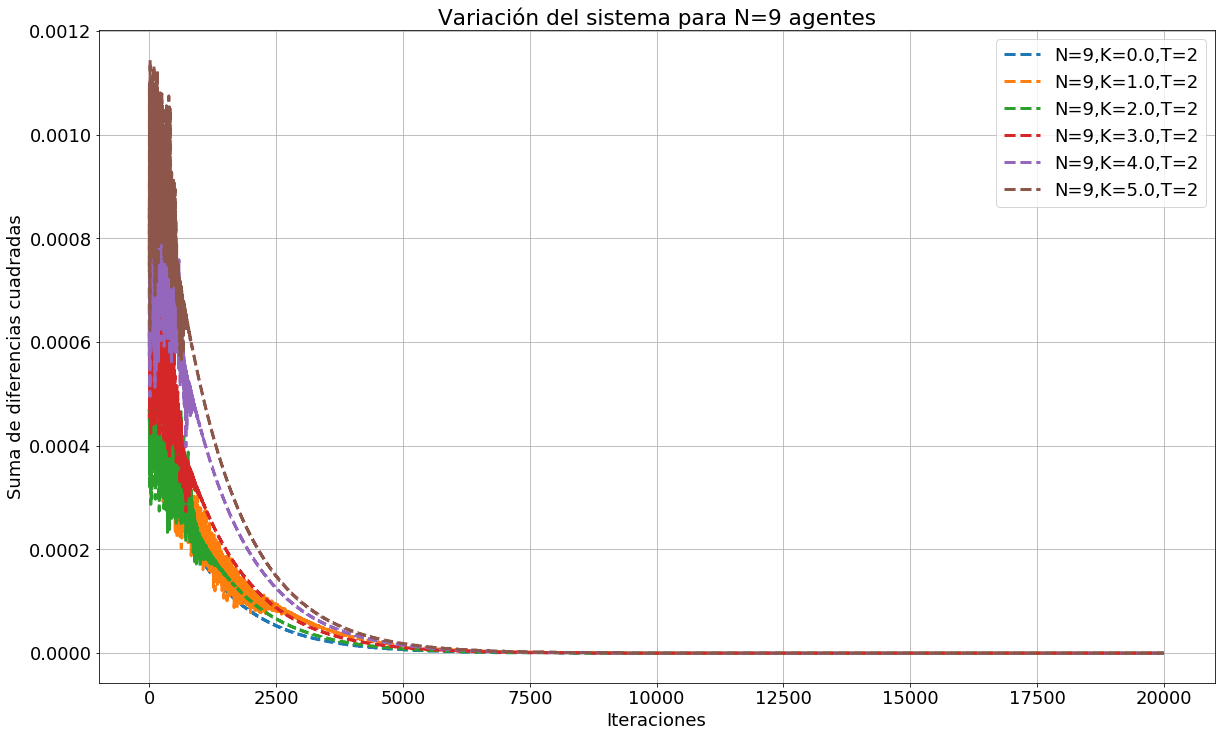

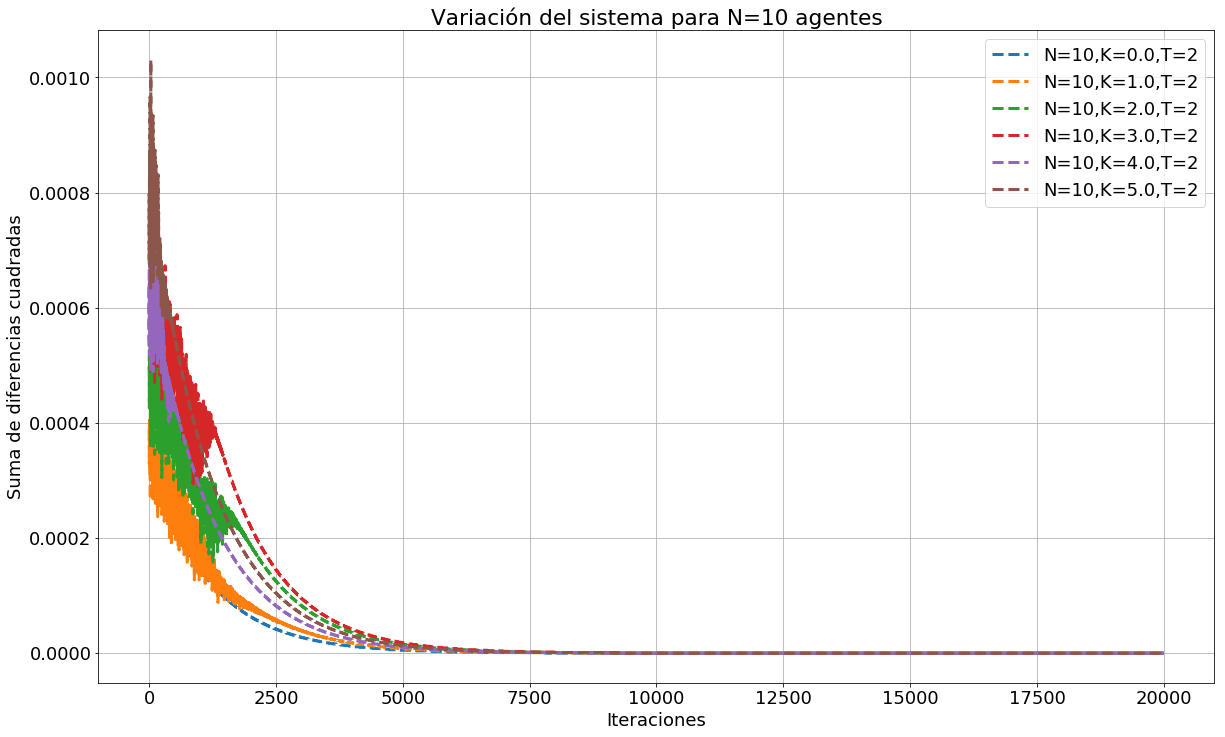

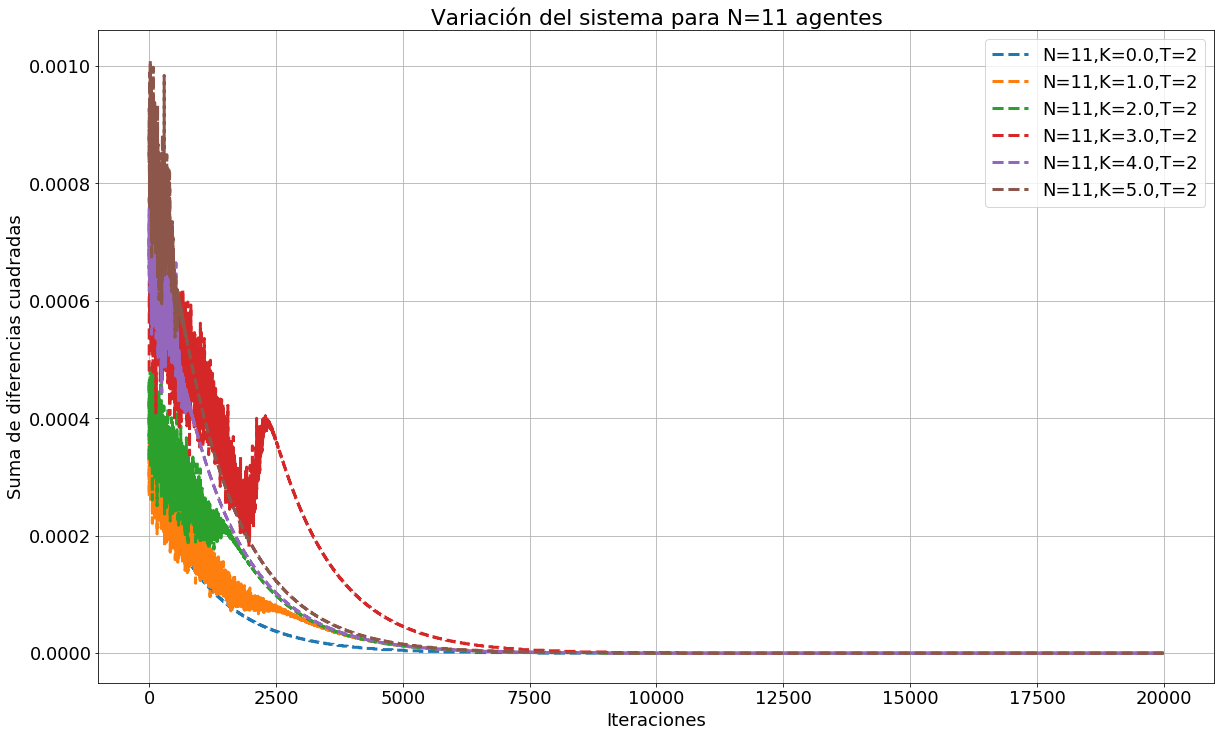

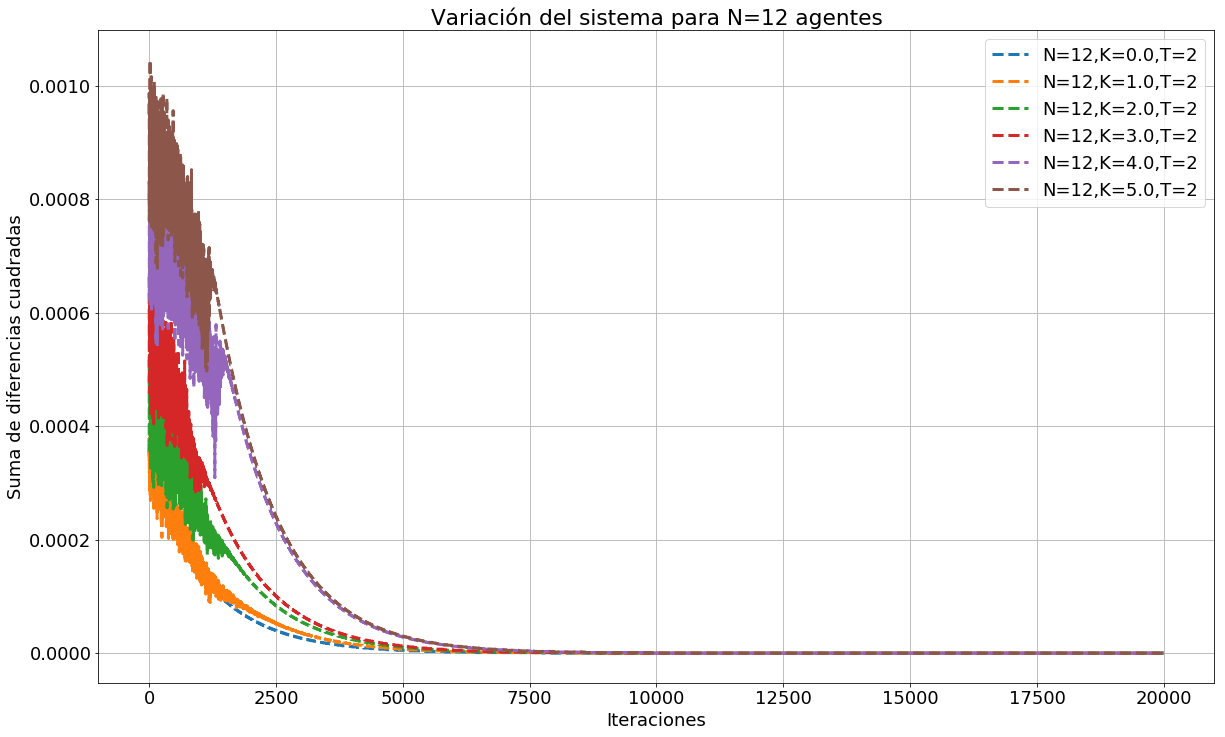

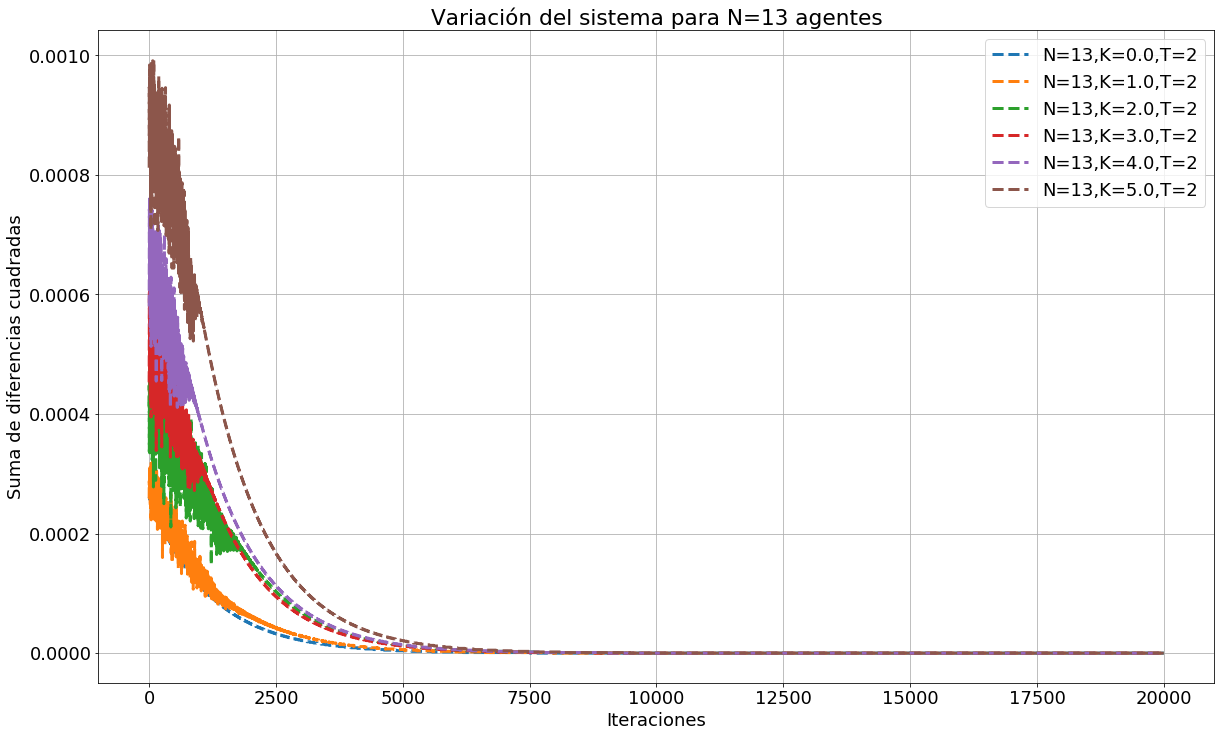

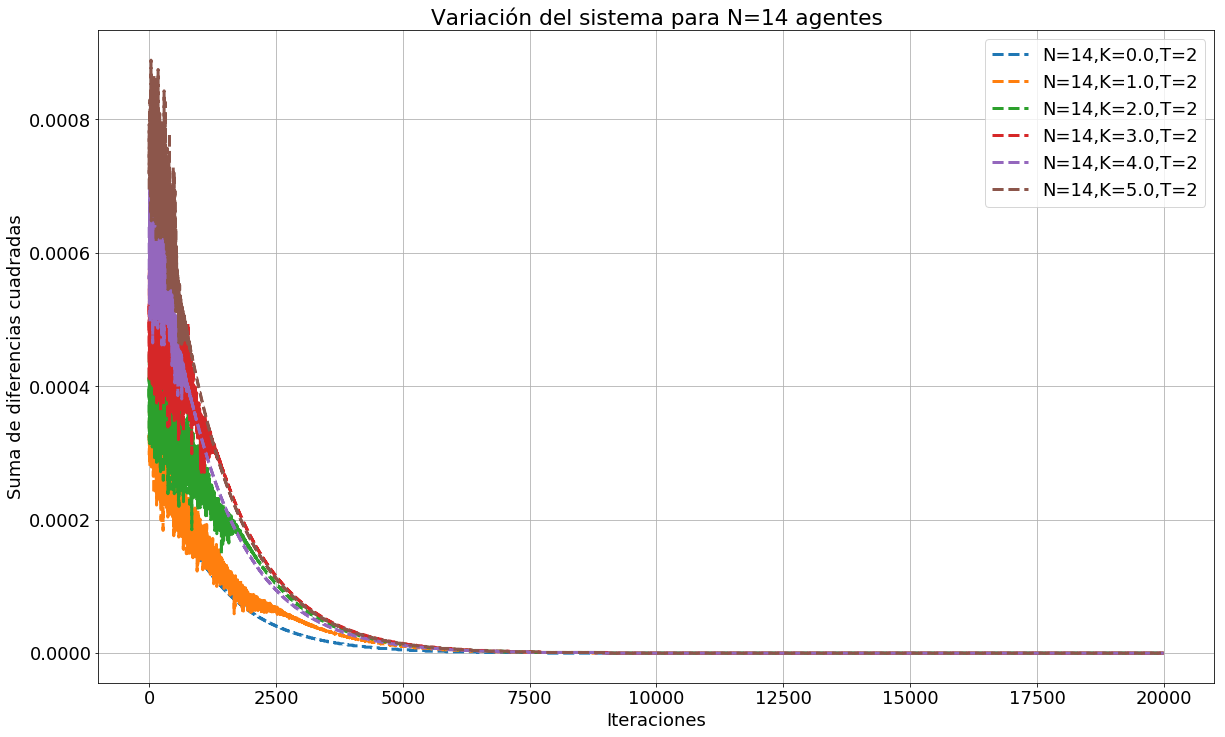

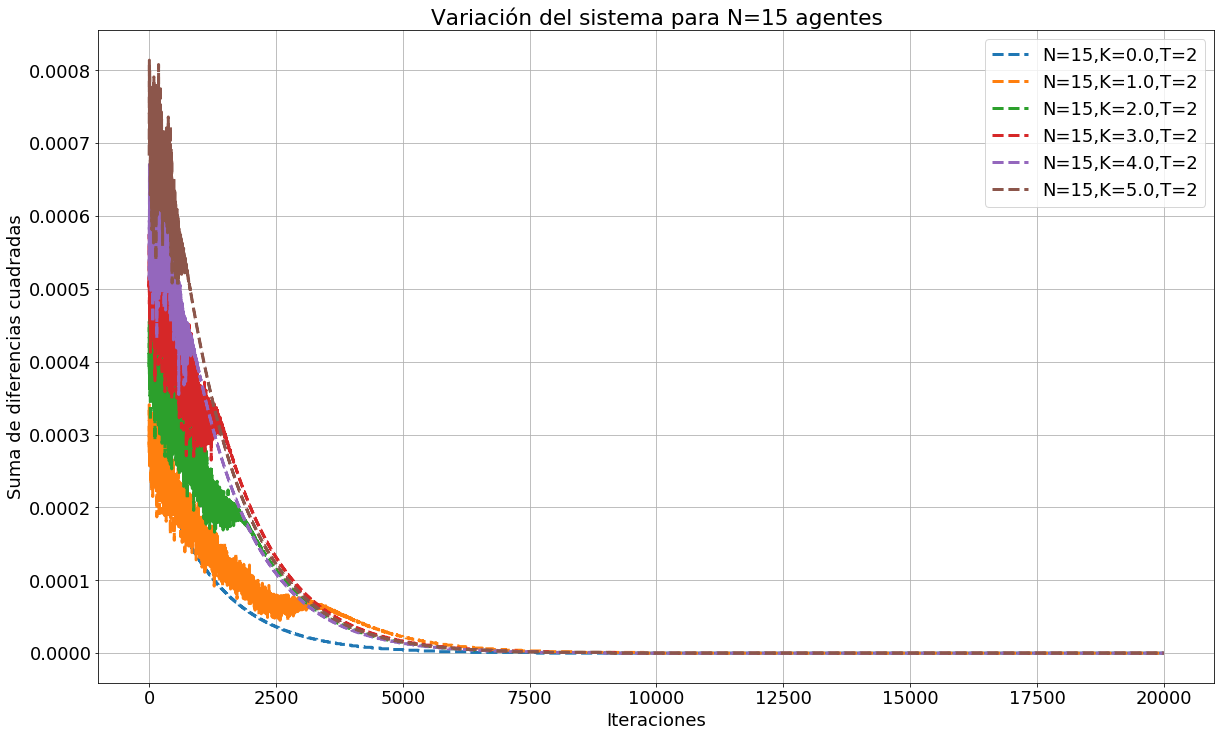

Esto tardó 13.094338178634644 segundos


In [8]:
t0 = time.time()

# En esta celda lo que voy a hacer es graficar los "errores" de mis sistemas. Es decir que voy a 
# estar mirando la suma del cuadrado de la diferencia del sistema en dos pasos temporales sucesivos. 
# La idea es ver cuánto cambia y a cuanto llega a medida que avanza en las iteraciones
# para poder establecer un criterio de corte de las iteraciones del sistema.

#--------------------------------------------------------------------------------------------

CarpCheck=[[root,files] for root,dirs,files in os.walk("./Datos Corte")]

# El comentario anterior era considerando que no le daba la dirección correcta
# de la carpeta con mi información al os.walk. Esta vez le estoy pasando la 
# dirección exacta, así que no es necesario hacer tanto quilombo para separar
# los nombres de los archivos. El elemento en la posición x[0] es el nombre de la carpeta

for x in CarpCheck:
    # dada = x[0].split("\\")
    Archivos_Datos = [nombre for nombre in x[1]]
    Archivos_Datos.insert(0,x[0])

# Con esto tengo los nombres de todos los archivos en la carpeta de Datos Corte
# Archivos_Datos tiene en la primer coordenada el principio de la dirección
# de la carpeta, y el resto de elementos son los archivos en la carpeta.
# Entonces si quiero buscar el objeto voy a tener que usar:
# Archivos_Datos[0]/Archivos_Datos[1]

#----------------------------------------------------------------------------

# Tengo dos tipos de archivos. Los de datos de opiniones tienen el siguiente formato:
# Datos_Evolucion_Opinion_N=$_T=$_K=$
# Los de datos de error cuadrático tienen el formato: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$
# Armemos dos listas, una con los nombres de las opiniones y otra con los nombres de los errores.
# En ambas listas el primer elemento va a ser la carpeta en la que se encuentran los datos.
# En esta celda voy a armar la lista de Nombres de Errores.
        
Nombres_Errores = [Archivos_Datos[0]]
for nombre in Archivos_Datos[1:len(Archivos_Datos)]:
    if nombre.split("_")[1] == "Errcuad":
        Nombres_Errores.append(nombre)

# Bien, las listas de nombres de archivos ya se arman correctamente

#-------------------------------------------------------------------------------------------

# Como el número de agentes de cada batch de datos no tiene porqué ser siempre el 
# mismo, me gustaría saber cuál es el máximo y mínimo número de agentes. Por razones.

Nmin = int(Nombres_Errores[1].split("_")[3].split("=")[1])
Nmax = int(Nombres_Errores[1].split("_")[3].split("=")[1])

# Defino un Nmin y Nmax inicial cualquiera, pero que esté dentro del conjunto total

for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
    N = int(nombre.split("_")[3].split("=")[1])
    Nmin = min(N,Nmin)
    Nmax = max(N,Nmax)

# Bien, esto ya me obtiene los valores de Nmin y Nmax correctamente

#-------------------------------------------------------------------------------------------

# Voy a iterar esto con todos los archivos de opiniones a ver que observo
for agentes in range(Nmin,Nmax+1):
    plt.figure(figsize=(20,12))
    for nombre in Nombres_Errores[1:len(Nombres_Errores)]:
        
        # Levanto los valores de N y T del nombre de mi archivo. Es importante recordar que mis
        # archivos tienen nombres de la forma: Datos_Errcuad_DiferenciaOpi_N=$_T=$_K=$

        N = int(nombre.split("_")[3].split("=")[1])
        T = int(nombre.split("_")[4].split("=")[1])
        K = float(nombre.split("_")[5].split("=")[1])

        # Los valores de N, T y K se levantan correctamente

        #--------------------------------------------------------------------------------------------
        if agentes==N:

            # Levanto los datos del archivo original y separo los datos en tres listas.
            # Una para la matriz de Adyacencia, una para la matriz de superposición y una para los vectores de opiniones

            Datos = ldata("{}/{}".format(Nombres_Errores[0],nombre))

            # Lista con elementos de los vectores de opinión. Al final sí había una forma compacta de hacer esto.
            # Si la matriz de Adyacencia evoluciona en el tiempo, va a haber que ver de hacer cambios acá.
            Err = [float(x) for x in Datos[0][1:len(Datos[0])]]

            # Mis listas ya se arman correctamente, tengo separados sin dramas los valores de mis tres matrices.

            #--------------------------------------------------------------------------------------------

            # Como lo único que tengo que graficar es el Error, ya tengo los datos armados. Sólo necesito
            # un vector X asociado.

            X = np.arange(0,len(Err))

            plt.plot(X,Err, "--",label="N={},K={},T={}".format(N,K,T) ,linewidth = 3)

    plt.rcParams.update({'font.size': 18})
    plt.xlabel("Iteraciones")
    plt.ylabel("Suma de diferencias cuadradas")
    plt.title("Variación del sistema para N={} agentes".format(agentes))
    plt.grid()
    plt.legend()
    plt.savefig("../Imagenes/Errores_Corte_N={}_T={}.png".format(agentes,T),bbox_inches = "tight")
    plt.show()


# El graficado de la función va bien, pero todavía siento que no puede bancarse cualquier cambio. Tengo que
# considerar un poco más los posibles casos.


Tiempo()